<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/8_3_Network_in_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.3 : Network in Network

In [ ]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [2]:
import torch
from d2l import torch as d2l
from torch import nn

In [3]:
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
  )

In [6]:
nn.AdaptiveAvgPool2d??

In [4]:
avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # target output : 1 x 1
b = torch.ones(1, 50, 10, 10) * 2
print(f"b.shape = {b.shape}")
c = avg_pool(b)
print(f"c.shape = {c.shape}")

b.shape = torch.Size([1, 50, 10, 10])
c.shape = torch.Size([1, 50, 1, 1])


In [5]:
flatten = nn.Flatten()
d = flatten(c)
print(d.shape)

torch.Size([1, 50])


In [4]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
class NiN(d2l.Classifier):

  def __init__(self, lr=0.01, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nin_block(384, kernel_size=3, strides=1, padding=1), 
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(p=0.5),
        nin_block(num_classes, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)), # computes average for all the pixels for each channel independently
        nn.Flatten() # giving us the required number of outputs for using cross entropy loss 
    )
    self.net.apply(d2l.init_cnn)

  def forward(self, X):
    return self.net(X)

In [7]:
l1 = nn.MaxPool2d(kernel_size=2, stride=2)
print(l1.__class__)
print(l1.__class__.__name__)

<class 'torch.nn.modules.pooling.MaxPool2d'>
MaxPool2d


In [8]:
model = NiN()
X = torch.randn(1, 1, 224, 224)
for layer in model.net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape \t', X.shape)

Sequential output shape 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape 	 torch.Size([1, 96, 26, 26])
Sequential output shape 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape 	 torch.Size([1, 256, 12, 12])
Sequential output shape 	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape 	 torch.Size([1, 384, 5, 5])
Dropout output shape 	 torch.Size([1, 384, 5, 5])
Sequential output shape 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape 	 torch.Size([1, 10, 1, 1])
Flatten output shape 	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
print(X)

tensor([[0.2553, 0.0000, 0.0000, 0.2528, 0.0439, 0.0000, 0.0000, 0.1504, 0.2526,
         0.0000]], grad_fn=<ReshapeAliasBackward0>)


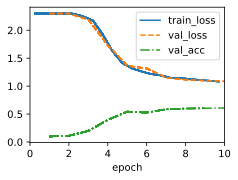

In [7]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [8]:
from torchsummary import summary
summary(NiN(lr=0.05).net, (1, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
class model(nn.Module):

  def __init__(self):
    super().__init__()
    self.net = nn.LazyLinear(4096)

  def forward(self, X):
    return self.net(X)

summary(model(), (1, 1, 25088), device='cpu') # a single fully connect layer with 4096 outputs in VGG block takes 10 times more memory than the enitre NiN model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 4096]     102,764,544
Total params: 102,764,544
Trainable params: 102,764,544
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.03
Params size (MB): 392.02
Estimated Total Size (MB): 392.14
----------------------------------------------------------------


Let's implement from scratch: 

In [8]:
import sys
print(sys.executable)

/usr/bin/python3


In [5]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

In [6]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

data = torchvision.datasets.FashionMNIST(root='./data1',
                                         train=True,
                                         download=True,
                                         transform=transform)

  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw



In [7]:
data[0][0].shape

torch.Size([1, 224, 224])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
#@title FashionMNIST class
class FashionMNIST():

  def __init__(self, batch_size):
    self.batch_size = batch_size
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    self.train_set = torchvision.datasets.FashionMNIST(root='./data',
                                                       download=True,
                                                       train=True,
                                                       transform = transform) # orignally the fashionMNIST dataset is PIL image
    self.test_set = torchvision.datasets.FashionMNIST(root='./data',
                                                      download=True,
                                                      train=False,
                                                      transform=transform)
    
  def get_dataloader(self, train):
    if train:
      return self.train_loader()
    else:
      return self.test_loader()
    
  def train_loader(self):
    t = torch.utils.data.DataLoader(dataset=self.train_set,
                                    batch_size=self.batch_size,
                                    shuffle=True,
                                    num_workers=2)
    return t
    
  def test_loader(self):
    t = torch.utils.data.DataLoader(dataset=self.test_set,
                                    batch_size=self.batch_size,
                                    shuffle=False,
                                    num_workers=2)
    
    return t

In [15]:
tot = 10000000

for i in range(tot):
  if (i+1)%(tot/2) == 0:
    print(i)

4999999
9999999


In [18]:
a = torch.randn(1, requires_grad=True)

with torch.no_grad():
  b = 2 + a
  t = b
  print(t)


tensor([0.7516])


In [19]:
import time
start = time.time()
m1 = torch.randn(100, 100)
m2 = torch.randn(100, 100)
m = torch.mm(m1, m2)
print("--- %s seconds ---" % (time.time() - start))

--- 0.03789329528808594 seconds ---


In [58]:
#@title Trainer Class code : 
class Trainer():

  def __init__(self, num_epochs):
    self.num_epochs = num_epochs
    self.train_loss = []
    self.val_loss = []
    self.val_acc = []

  def fit(self, model, data):

    start = time.time()
    # training loop : 
    train_loader = data.get_dataloader(True)
    test_loader = data.get_dataloader(False)
    optimizer = torch.optim.SGD(model.parameters(), model.lr)
    criterion = nn.CrossEntropyLoss()
    n_total_steps = len(train_loader)

    for epoch in range(self.num_epochs):
      t_loss = torch.zeros(1)
      # training loop : 
      for i, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        outputs = model(features)
        loss = criterion(outputs, targets)
        t_loss += loss.detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1)%(self.num_epochs/10) == 0 and (i+1)%(n_total_steps/2) == 0:
          print(f"epoch : {epoch+1}/{self.num_epochs}, step : {i+1}/{n_total_steps}, loss : {loss.item():.4f}")

      self.train_loss.append(t_loss)

      # test loop : 
      with torch.no_grad():
        n_samples = 0.0
        n_correct = 0.0
        v_loss = torch.zeros(1)
        for features, targets in test_loader:

          features = features.to(device)
          targets = targets.to(device)

          outputs = model(features)
          loss = criterion(outputs, targets)
          v_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          n_samples += targets.shape[0]
          n_correct += (preds == targets).sum().item()

        acc = 100 * (n_correct / n_samples)
        self.val_acc.append(acc)
        self.val_loss.append(v_loss)

      print(f"Finished Training in {time.time()-start:.2f} seconds")

In [9]:
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
  )

In [39]:
d2l.init_cnn

In [40]:
def init_cnn(module):
  if type(module) == nn.Conv2d or type(module) == nn.Linear:
    nn.init.xavier_uniform_(module.weight)

In [41]:
#@title NiN class
class NiN(nn.Module):

  def __init__(self, lr=0.05, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nin_block(384, kernel_size=3, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(p=0.5),
        nin_block(num_classes, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [32]:
from torchsummary import summary
model = NiN()
summary(model, (1, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
d2l.init_cnn

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
d = FashionMNIST(batch_size=128)
train = d.get_dataloader(train=True)

In [30]:
examples = next(iter(train))

In [35]:
next(iter(train))[0][0].shape

torch.Size([1, 224, 224])

In [31]:
features, targets = examples
print(features.shape)
print(targets.shape)

torch.Size([128, 1, 224, 224])
torch.Size([128])


In [38]:
d2l.Module.apply_init

Object `d2l.apply_init` not found.


In [48]:
model = NiN()
data = FashionMNIST(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init=init_cnn)
model = model.to(device)
trainer = Trainer(num_epochs=10)
trainer.fit(model, data)

epoch : 1/10, step : 469/469, loss : 2.3027
Finished Training in 70.24943685531616 seconds
epoch : 2/10, step : 469/469, loss : 2.3025
Finished Training in 140.55046105384827 seconds
epoch : 3/10, step : 469/469, loss : 2.2647
Finished Training in 210.99098825454712 seconds
epoch : 4/10, step : 469/469, loss : 1.6786
Finished Training in 281.166140794754 seconds
epoch : 5/10, step : 469/469, loss : 0.8079
Finished Training in 351.3831284046173 seconds
epoch : 6/10, step : 469/469, loss : 0.5448
Finished Training in 421.46472358703613 seconds
epoch : 7/10, step : 469/469, loss : 0.6721
Finished Training in 492.06596088409424 seconds
epoch : 8/10, step : 469/469, loss : 0.5215
Finished Training in 562.5485315322876 seconds
epoch : 9/10, step : 469/469, loss : 0.5082
Finished Training in 633.1989538669586 seconds
epoch : 10/10, step : 469/469, loss : 0.5887
Finished Training in 703.9011731147766 seconds


In [50]:
trainer.train_loss

[tensor([1080.1505]),
 tensor([1079.7717]),
 tensor([1070.0380]),
 tensor([890.6583]),
 tensor([497.7125]),
 tensor([327.8217]),
 tensor([277.1233]),
 tensor([244.3626]),
 tensor([221.1949]),
 tensor([204.2803])]

In [51]:
trainer.val_loss

[tensor([181.8941]),
 tensor([181.8322]),
 tensor([177.1063]),
 tensor([123.7993]),
 tensor([73.6670]),
 tensor([52.6037]),
 tensor([53.8539]),
 tensor([38.8749]),
 tensor([37.9160]),
 tensor([36.3016])]

In [49]:
trainer.val_acc

[10.0,
 11.82,
 20.880000000000003,
 43.05,
 61.94,
 76.38000000000001,
 72.92,
 81.78,
 81.91000000000001,
 82.32000000000001]

## Ex 8.3:

### Q1:

changing the number of 1x1 convs in nin_block:

- 1 layer : acc = 87.27% (lr=0.05), 82.95% (lr=0.1) 
- 2 layers : acc = 82.32% (lr=0.05)
- 3 layers : acc = 60.62% (lr=0.1), lr=0.05 not working for this one

In [74]:
def mod_nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
      # let's use 3 1x1 conv layers
      nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
  )

In [75]:
class NiN1(nn.Module):

  def __init__(self, lr=0.01, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        mod_nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),
        mod_nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        mod_nin_block(384, kernel_size=3, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(p=0.5),
        mod_nin_block(num_classes, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [80]:
model = NiN1(lr=0.1)
data = FashionMNIST(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init=init_cnn)
model = model.to(device)
trainer = Trainer(num_epochs=10)
trainer.fit(model, data)

epoch : 1/10, step : 469/469, loss : 0.9384
Finished Training in 53.07 seconds
epoch : 2/10, step : 469/469, loss : 0.5674
Finished Training in 107.48 seconds
epoch : 3/10, step : 469/469, loss : 0.7406
Finished Training in 160.22 seconds
epoch : 4/10, step : 469/469, loss : 0.5877
Finished Training in 212.97 seconds
epoch : 5/10, step : 469/469, loss : 0.4590
Finished Training in 265.88 seconds
epoch : 6/10, step : 469/469, loss : 0.7563
Finished Training in 319.31 seconds
epoch : 7/10, step : 469/469, loss : 0.4786
Finished Training in 371.98 seconds
epoch : 8/10, step : 469/469, loss : 0.5778
Finished Training in 424.74 seconds
epoch : 9/10, step : 469/469, loss : 0.6461
Finished Training in 477.32 seconds
epoch : 10/10, step : 469/469, loss : 0.4189
Finished Training in 530.39 seconds


In [60]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

rcParams['figure.figsize'] = 16, 8
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler(color = ['#424242'])
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


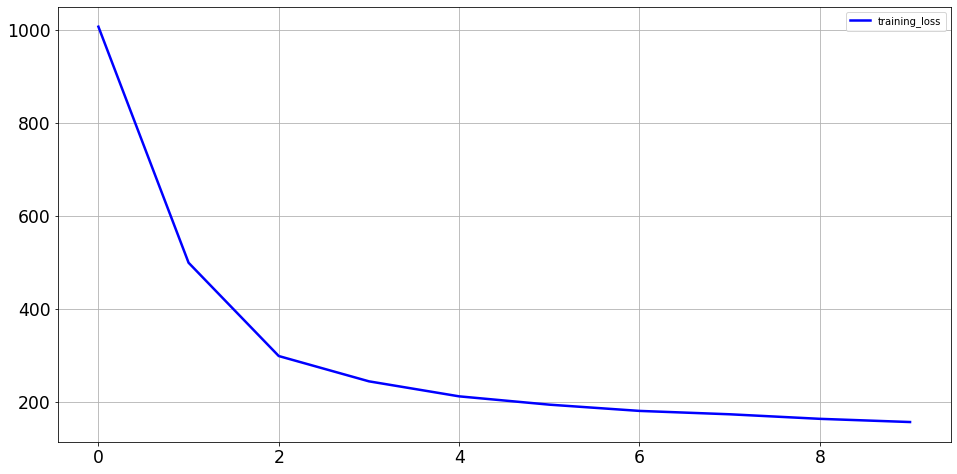

In [77]:
plt.plot(list(range(trainer.num_epochs)), trainer.train_loss, 'b-', label='training_loss')
plt.grid()
plt.legend();

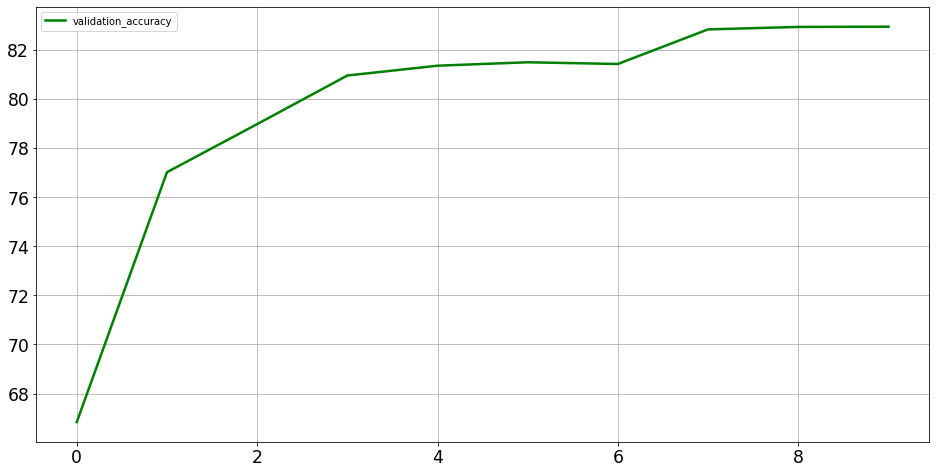

In [81]:
plt.plot(list(range(trainer.num_epochs)), trainer.val_acc, 'g-', label='validation_accuracy')
plt.grid()
plt.legend();

In [82]:
trainer.val_acc[-1]

82.95

### Q2 : 

replacing 1x1 convs with 3x3 convs:

- 3x3 convs, 3 layers : 79.92%
- 3x3 convs, 2 layers : 86.27%

In [90]:
def mod_nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU()
  )

In [91]:
class NiN1(nn.Module):

  def __init__(self, lr=0.01, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        mod_nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),
        mod_nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        mod_nin_block(384, kernel_size=3, strides=1, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(p=0.5),
        mod_nin_block(num_classes, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [92]:
model = NiN1(lr=0.05)
data = FashionMNIST(batch_size=128)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init=init_cnn)
model = model.to(device)
trainer = Trainer(num_epochs=10)
trainer.fit(model, data)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch : 1/10, step : 469/469, loss : 2.3025
Finished Training in 138.87 seconds
epoch : 2/10, step : 469/469, loss : 2.1874
Finished Training in 276.57 seconds
epoch : 3/10, step : 469/469, loss : 1.4244
Finished Training in 413.76 seconds
epoch : 4/10, step : 469/469, loss : 1.0095
Finished Training in 551.85 seconds
epoch : 5/10, step : 469/469, loss : 0.7383
Finished Training in 689.95 seconds
epoch : 6/10, step : 469/469, loss : 0.5331
Finished Training in 828.27 seconds
epoch : 7/10, step : 469/469, loss : 0.4338
Finished Training in 966.65 seconds
epoch : 8/10, step : 469/469, loss : 0.3103
Finished Training in 1105.02 seconds
epoch : 9/10, step : 469/469, loss : 0.3681
Finished Training in 1243.49 seconds
epoch : 10/10, step : 469/469, loss : 0.2568
Finished Training in 1382.03 seconds


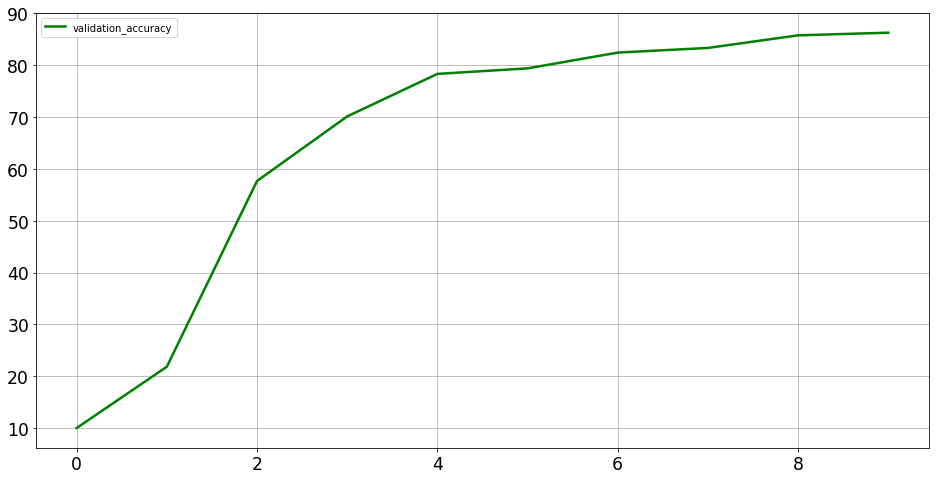

In [93]:
plt.plot(list(range(trainer.num_epochs)), trainer.val_acc, 'g-', label='validation_accuracy')
plt.grid()
plt.legend();

In [94]:
trainer.val_acc[9]

86.27